In [1]:
import pandas as pd

In [2]:
df = pd.read_json('data_dump_full.csv', lines=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110931 entries, 0 to 110930
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     110931 non-null  int64  
 1   source_name                            110931 non-null  object 
 2   content_rendered                       110931 non-null  object 
 3   reply_count                            110931 non-null  int64  
 4   share_count                            110931 non-null  int64  
 5   like_count                             110931 non-null  int64  
 6   quote_count                            110931 non-null  int64  
 7   bert_finetuned_propaganda_18           110931 non-null  object 
 8   distilroberta_propaganda_2class        110931 non-null  object 
 9   twitter_roberta_base_emotion           110931 non-null  object 
 10  twitter_roberta_base_sentiment_latest  110931 non-null  

In [4]:
df_filtered = df[[
#     'id', 
    'source_name', 
    'content_rendered', 
    'reply_count',
    'share_count',
    'like_count',
    'quote_count',
    'bert_finetuned_propaganda_18',
    'distilroberta_propaganda_2class',
    'twitter_roberta_base_emotion',
    'twitter_roberta_base_sentiment_latest',
    'claimbuster_score',
    'hashtag_centrality',
    'reference_centrality',
    'credible_domain_centrality',
    'uncredible_domain_centrality'
]]

In [5]:
# df_filtered = df_filtered.fillna(0)


In [6]:
df_filtered['bert_propaganda_verdict'] = df_filtered['bert_finetuned_propaganda_18'].apply(lambda x: 1 if max(x, key=x.get) not in ['','0'] else 0)
df_filtered['distilroberta_propaganda_verdict'] = df_filtered['distilroberta_propaganda_2class'].apply(lambda x: 1 if max(x, key=x.get) == 'Prop' else 0)

df_filtered['verdict'] = (df_filtered['distilroberta_propaganda_verdict'] + df_filtered['bert_propaganda_verdict']) == 2
df_filtered['verdict']=df_filtered['verdict'].astype(int)

In [7]:
for feature in ['joy', 'optimism', 'anger', 'sadness']:
    df_filtered[f'feature__emotion_{feature}'] = df_filtered['twitter_roberta_base_emotion'].apply(lambda x: x[feature])
for feature in ['negative', 'neutral', 'positive']:
    df_filtered[f'feature__sentiment_{feature}'] = df_filtered['twitter_roberta_base_sentiment_latest'].apply(lambda x: x[feature])

# for feature in ['O', 'Appeal_to_fear_prejudice', 'Flag_Waving', 'Causal_Oversimplification', 'Whataboutism', 'Reductio_ad_hitlerum', 'Black_and_White_Fallacy', 'Red_Herring', 'Bandwagon', 'Obfuscation,Intentional_Vagueness,Confusion', 'Straw_Men', '', 'Slogans', 'Loaded_Language', 'Repetition', 'Name_Calling,Labeling', 'Doubt', 'Exaggeration,Minimisation', 'Thought_terminating_Cliches', 'Appeal_to_Authority']:
#     df_filtered[f'feature__bert_propaganda_{feature}'] = df_filtered['bert_finetuned_propaganda_18'].apply(lambda x: x[feature])
# for feature in ['Prop', 'No_Prop']:
#     df_filtered[f'feature__distilroberta_propaganda_{feature}'] = df_filtered['distilroberta_propaganda_2class'].apply(lambda x: x[feature])
    
additional_features = ['source_name', 'reply_count', 'share_count', 
                       'like_count', 'quote_count', 'claimbuster_score',
                       'hashtag_centrality', 'reference_centrality', 
                       'credible_domain_centrality', 'uncredible_domain_centrality']
for feature in additional_features:
    df_filtered[f'feature__{feature}'] = df_filtered[feature]

In [8]:
columns = [column for column in df_filtered.columns.to_list() if column.startswith('feature__') or column in ['id']]
columns.append('verdict')

In [9]:
df_features = df_filtered[columns]

In [10]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110931 entries, 0 to 110930
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   feature__emotion_joy                   110931 non-null  float64
 1   feature__emotion_optimism              110931 non-null  float64
 2   feature__emotion_anger                 110931 non-null  float64
 3   feature__emotion_sadness               110931 non-null  float64
 4   feature__sentiment_negative            110931 non-null  float64
 5   feature__sentiment_neutral             110931 non-null  float64
 6   feature__sentiment_positive            110931 non-null  float64
 7   feature__source_name                   110931 non-null  object 
 8   feature__reply_count                   110931 non-null  int64  
 9   feature__share_count                   110931 non-null  int64  
 10  feature__like_count                    110931 non-null  

In [11]:
df_features.to_csv('features.csv', index=False)

In [12]:
import pandas as pd

In [13]:
df_features = pd.read_csv('features.csv')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110931 entries, 0 to 110930
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   feature__emotion_joy                   110931 non-null  float64
 1   feature__emotion_optimism              110931 non-null  float64
 2   feature__emotion_anger                 110931 non-null  float64
 3   feature__emotion_sadness               110931 non-null  float64
 4   feature__sentiment_negative            110931 non-null  float64
 5   feature__sentiment_neutral             110931 non-null  float64
 6   feature__sentiment_positive            110931 non-null  float64
 7   feature__source_name                   110931 non-null  object 
 8   feature__reply_count                   110931 non-null  int64  
 9   feature__share_count                   110931 non-null  int64  
 10  feature__like_count                    110931 non-null  

In [14]:
import lightgbm as lgbm  # standard alias
from sklearn.model_selection import train_test_split


In [15]:
df_features.columns = [arg.replace(',', '') for arg in df_features.columns]

In [16]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['feature__source_name']
df_features_subset = df_features.sample(frac=1).reset_index(drop=True)

# Convert cat_features to pd.Categorical dtype
le_dict = {}
for col in cat_features:
    le = LabelEncoder()
    df_features_subset[col] = le.fit_transform(df_features_subset[col])
    le_dict[col] = le
    df_features_subset[col] = df_features_subset[col].astype('category')


X = df_features_subset.drop(['verdict'], axis=1)
y = df_features_subset['verdict'].values


# Unencoded train/test sets
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, stratify=y
)

lgb_train = lgbm.Dataset(X_train, y_train, categorical_feature=cat_features,
                        free_raw_data=False)
lgb_eval = lgbm.Dataset(X_eval, y_eval, categorical_feature=cat_features,
                       free_raw_data=False)

In [17]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary', 'auc'],
    'learning_rate': 0.005,
    "num_leaves": 128,  
    "max_bin": 512,
}

model = lgbm.train(hyper_params, lgb_train, num_boost_round=100, early_stopping_rounds=20,
                   verbose_eval=True, valid_sets=lgb_eval)



/home/sparkh/Projects/hobby/hackathon/team-valkyrie-2/venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sparkh/Projects/hobby/hackathon/team-valkyrie-2/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/sparkh/Projects/hobby/hackathon/team-valkyrie-2/venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future relea

[LightGBM] [Info] Number of positive: 18301, number of negative: 70443
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8746
[LightGBM] [Info] Number of data points in the train set: 88744, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206222 -> initscore=-1.347848
[LightGBM] [Info] Start training from score -1.347848
[1]	valid_0's binary_logloss: 0.507757	valid_0's auc: 0.813942
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.506581	valid_0's auc: 0.8155
[3]	valid_0's binary_logloss: 0.50543	valid_0's auc: 0.815494
[4]	valid_0's binary_logloss: 0.504292	valid_0's auc: 0.816063
[5]	valid_0's binary_logloss: 0.503151	valid_0's auc: 0.819161
[6]	valid_0's binary_logloss: 0.502034	valid_0's auc: 0.819976
[7]	valid_0's binary_logloss: 0.500923	valid_0's auc: 0.820502
[8]	

acc on eval: 0.78690
roc_auc on eval: : 0.83082


<AxesSubplot: >

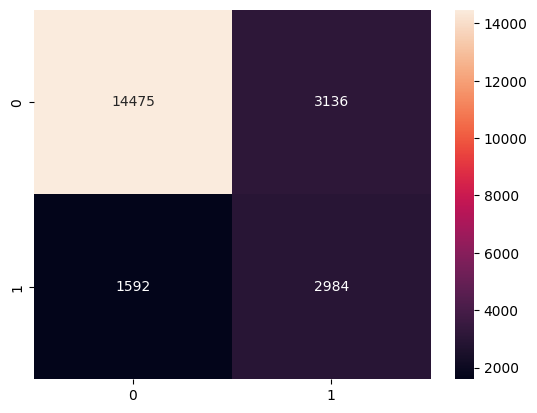

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score
import seaborn as sns

preds = model.predict(X_eval)
preds_class = [1 if x >= 0.25 else 0 for x in preds]
print(f"acc on eval: {accuracy_score(y_eval, preds_class):.5f}")
print(f"roc_auc on eval: : {roc_auc_score(y_eval, preds):.5f}")

sns.heatmap(confusion_matrix(y_eval, preds_class), annot=True, fmt='g')

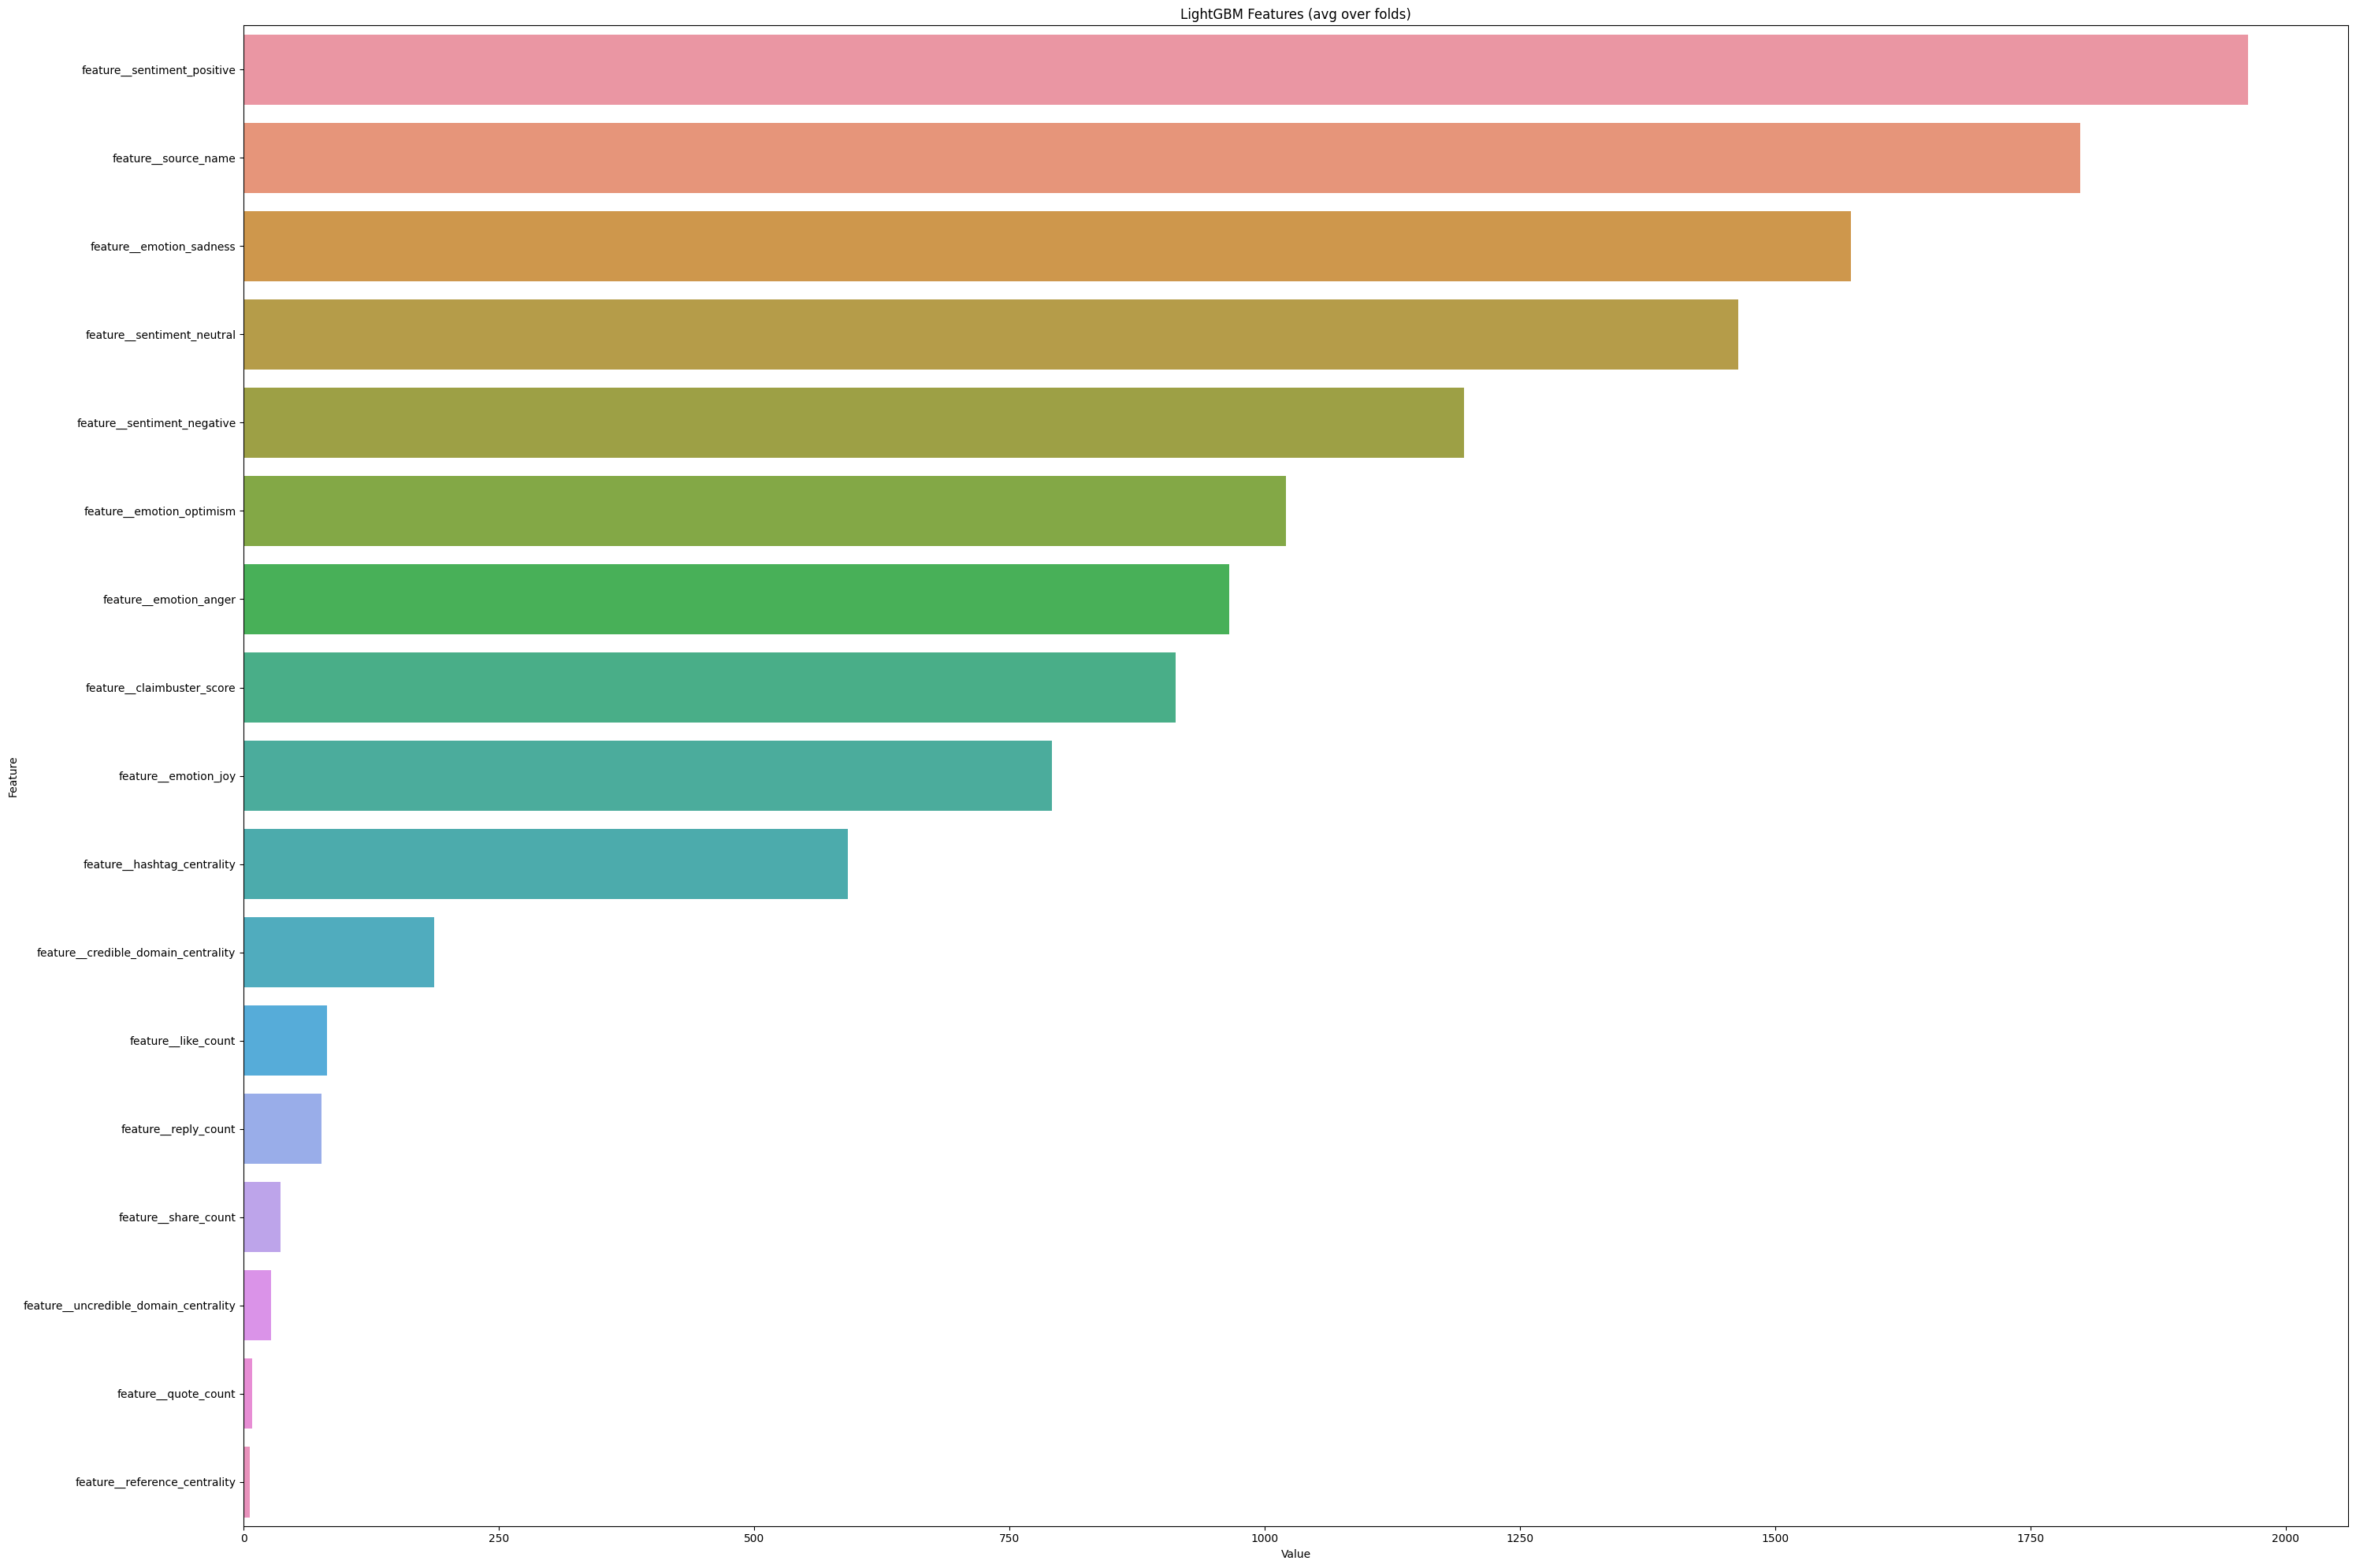

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(30, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

(array([9979., 3130., 2632., 2261., 1844., 1447.,  536.,  177.,   84.,
          97.]),
 array([0.12898622, 0.16767078, 0.20635533, 0.24503989, 0.28372444,
        0.322409  , 0.36109355, 0.39977811, 0.43846266, 0.47714722,
        0.51583177]),
 <BarContainer object of 10 artists>)

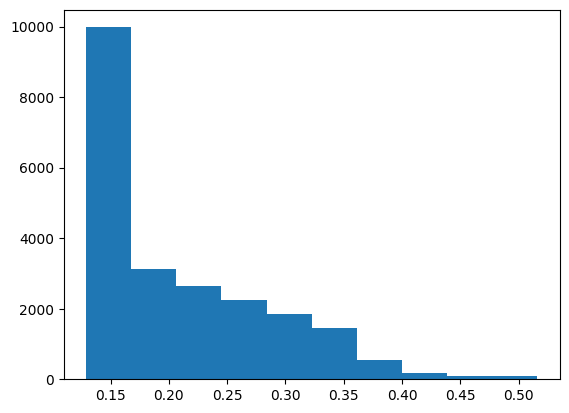

In [21]:
plt.hist(preds)

In [24]:
lgb_train_all = lgbm.Dataset(X, y, categorical_feature=cat_features,
                        free_raw_data=False)

results = lgbm.cv(hyper_params, lgb_train_all, num_boost_round=500, early_stopping_rounds=20, 
        nfold=10, metrics=['binary', 'auc'])

/home/sparkh/Projects/hobby/hackathon/team-valkyrie-2/venv/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sparkh/Projects/hobby/hackathon/team-valkyrie-2/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 20589, number of negative: 79248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9005
[LightGBM] [Info] Number of data points in the train set: 99837, number of used features: 17
[LightGBM] [Info] Number of positive: 20589, number of negative: 79249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9005
[LightGBM] [Info] Number of data points in the train set: 99838, number of used features: 17
[LightGBM] [Info] Number of positive: 20589, number of negative: 79249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9005
[Lig

In [ ]:
preds = model.predict(X_eval)
preds_class = [1 if x >= 0.25 else 0 for x in preds]
print(f"acc on eval: {accuracy_score(y_eval, preds_class):.5f}")
print(f"roc_auc on eval: : {roc_auc_score(y_eval, preds):.5f}")

sns.heatmap(confusion_matrix(y_eval, preds_class), annot=True, fmt='g')

In [32]:
import numpy as np
np.array(results['auc-mean']).mean()

0.8388327470180919